## 知識情報学第4回サンプルプログラム ex4.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2021/10/26
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT License

## ゴルフプレイデータのナイーブベイズ分類器による識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.naive_bayes import CategoricalNB
import matplotlib.pyplot as plt
import pandas as pd

### arffデータの読み込み

In [2]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
data, meta

(array([(b'sunny', b'hot', b'high', b'FALSE', b'no'),
        (b'sunny', b'hot', b'high', b'TRUE', b'no'),
        (b'overcast', b'hot', b'high', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'TRUE', b'no'),
        (b'overcast', b'cool', b'normal', b'TRUE', b'yes'),
        (b'sunny', b'mild', b'high', b'FALSE', b'no'),
        (b'sunny', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'normal', b'FALSE', b'yes'),
        (b'sunny', b'mild', b'normal', b'TRUE', b'yes'),
        (b'overcast', b'mild', b'high', b'TRUE', b'yes'),
        (b'overcast', b'hot', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'TRUE', b'no')],
       dtype=[('outlook', 'S8'), ('temperature', 'S4'), ('humidity', 'S6'), ('windy', 'S5'), ('play', 'S3')]),
 Dataset: weather.symbolic
 	outlook's type is nominal, range is ('sunny', 'overcast', 'rainy

In [3]:
#dataの数
len(data)

14

In [4]:
df = pd.DataFrame(data)

In [5]:
df.head(14)

,outlook,temperature,humidity,windy,play
0,b'sunny',b'hot',b'high',b'FALSE',b'no'
1,b'sunny',b'hot',b'high',b'TRUE',b'no'
2,b'overcast',b'hot',b'high',b'FALSE',b'yes'
3,b'rainy',b'mild',b'high',b'FALSE',b'yes'
4,b'rainy',b'cool',b'normal',b'FALSE',b'yes'
5,b'rainy',b'cool',b'normal',b'TRUE',b'no'
6,b'overcast',b'cool',b'normal',b'TRUE',b'yes'
7,b'sunny',b'mild',b'high',b'FALSE',b'no'
8,b'sunny',b'cool',b'normal',b'FALSE',b'yes'
9,b'rainy',b'mild',b'normal',b'FALSE',b'yes'


### LabelEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [6]:
le = [LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),LabelEncoder()]
for idx,attr in enumerate(meta):
    le[idx].fit(list(meta[attr][1]))

class_array = np.array([])
feature_array = np.zeros((0,4))

for x in data:
    w = list(x)
    class_array = np.append(class_array, le[-1].transform(w[-1].decode("utf-8").split()))
    w.pop(-1)
    for idx in range(0, len(w)):
        w[idx] = le[idx].transform(w[idx].decode("utf-8").split())
    temp = np.array(w)
    feature_array = np.append(feature_array, np.ravel(temp).reshape(1,-1), axis=0)

for i,j in zip(feature_array, class_array):
    print(i,j)

[2. 1. 0. 0.] 0.0
[2. 1. 0. 1.] 0.0
[0. 1. 0. 0.] 1.0
[1. 2. 0. 0.] 1.0
[1. 0. 1. 0.] 1.0
[1. 0. 1. 1.] 0.0
[0. 0. 1. 1.] 1.0
[2. 2. 0. 0.] 0.0
[2. 0. 1. 0.] 1.0
[1. 2. 1. 0.] 1.0
[2. 2. 1. 1.] 1.0
[0. 2. 0. 1.] 1.0
[0. 1. 1. 0.] 1.0
[1. 2. 0. 1.] 0.0


### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．
- 【課題2】スムージングパラメータalphaを変更してみましょう．
- 【課題3】事前確率class_priorを変更してみましょう．

In [7]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_array):
    X_train, X_test = feature_array[train_index], feature_array[test_index]
    y_train, y_test = class_array[train_index], class_array[test_index]

    # =====================================================================
    # 課題1(a) ナイーブベイズ分類器のインスタンスを生成し，学習データに適合させる．
    # カテゴリカルナイーブベイズ（CategoricalNB）を使用する．
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB
    # alpha(>0)はスムージングのパラメータ．
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    
    clf_nb = CategoricalNB(class_prior = [0.2,0.8])
    clf_nb.fit(X_train,y_train)    

    # =====================================================================
    # 課題1(b) 学習データとテストデータに対する各クラスの事後確率を算出
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = clf_nb.predict_proba(X_train)
    posterior_tst = clf_nb.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.31989425 0.68010575]]
True Label: [0.]
Posterior Probability: [[0.55251142 0.44748858]]
True Label: [1.]
Posterior Probability: [[0.23161973 0.76838027]]
True Label: [1.]
Posterior Probability: [[0.37612215 0.62387785]]
True Label: [1.]
Posterior Probability: [[0.0968031 0.9031969]]
True Label: [0.]
Posterior Probability: [[0.03201341 0.96798659]]
True Label: [1.]
Posterior Probability: [[0.06668724 0.93331276]]
True Label: [0.]
Posterior Probability: [[0.22010005 0.77989995]]
True Label: [1.]
Posterior Probability: [[0.17651864 0.82348136]]
True Label: [1.]
Posterior Probability: [[0.10760147 0.89239853]]
True Label: [1.]
Posterior Probability: [[0.3913831 0.6086169]]
True Label: [1.]
Posterior Probability: [[0.28669181 0.71330819]]
True Label: [1.]
Posterior Probability: [[0.05685983 0.94314017]]
True Label: [0.]
Posterior Probability: [[0.27029039 0.72970961]]


### ROC曲線の描画とAUCの算出
- roc_curve
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
- roc_auc_score
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
- auc
    - 関数roc_auc_scoreの代わりに関数aucを使用してもよい
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc

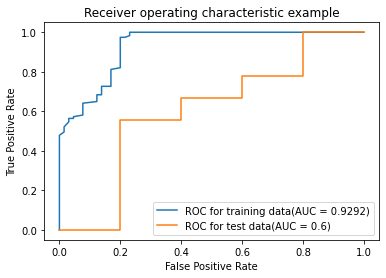

In [8]:
# 課題1(c) 学習データおよびテストデータに対するROC曲線の描画とAUCを算出する

# false positive rate, true positionve rate の計算
fpr_train, tpr_train, threshold_train = roc_curve(y_train_list, y_train_post_list)
fpr_test, tpr_test, threshold_test = roc_curve(y_test_list, y_test_post_list)

# AUC score の計算
auc_train = roc_auc_score(y_train_list, y_train_post_list)
auc_test = roc_auc_score(y_test_list, y_test_post_list)

plt.plot(fpr_train, tpr_train, label = f'ROC for training data(AUC = {auc_train:.4})')
plt.plot(fpr_test, tpr_test, label = f'ROC for test data(AUC = {auc_test:.4})')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

## 課題4-2 スムージングパラメータ $\alpha$ を変更して考察

まず，スムージングパラメータ $\alpha$ は事後確率分布を計算する際の尤度計算の時に現れる．  
以下はスムージングパラメータを含めた尤度の計算式である．
$$
P\left(x_{j} \mid w_{i}\right)=\frac{n_{i j}+\alpha}{n_{i}+\alpha m_{j}}
$$


ここで, $x_j$は観測された(入力となる特徴量)データの$j$番目特徴量であり，$w_i$は$j$番目特徴量のとりうる$i$番目クラスという意味である．  
$m_j$は$j$番目特徴量がとりうるクラスの数，　$n_i$はクラス$w_i$の出現回数, $n_{ij}$はクラス$w_i$のうち値$x_j$を取るものの出現回数を表す．

計算式より$\alpha$が大きくなるにつれて$P\left(x_{j} \mid w_{i}\right)$の値は$1/m_j$に近づいていくことがわかる． 
つまり，$\alpha$の増加に伴って$w_i$のクラスのうちありうる全ての実現値が等確率で実現するというようなモデルに近づいていく． 

まずは$\alpha = 0$ の時について考える

True Label: [0.]
Posterior Probability: [[0.34808213 0.65191787]]
True Label: [0.]
Posterior Probability: [[0.68109623 0.31890377]]
True Label: [1.]
Posterior Probability: [[8.73813333e-11 1.00000000e+00]]
True Label: [1.]
Posterior Probability: [[0.46632891 0.53367109]]
True Label: [1.]
Posterior Probability: [[0.0615052 0.9384948]]
True Label: [0.]
Posterior Probability: [[7.91015625e-22 1.00000000e+00]]
True Label: [1.]
Posterior Probability: [[8.192e-12 1.000e+00]]
True Label: [0.]
Posterior Probability: [[0.21071394 0.78928606]]
True Label: [1.]
Posterior Probability: [[0.16430443 0.83569557]]
True Label: [1.]
Posterior Probability: [[0.08035942 0.91964058]]
True Label: [1.]
Posterior Probability: [[0.49572374 0.50427626]]
True Label: [1.]
Posterior Probability: [[1.09226667e-10 1.00000000e+00]]
True Label: [1.]
Posterior Probability: [[8.73813333e-12 1.00000000e+00]]
True Label: [0.]
Posterior Probability: [[0.2625135 0.7374865]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in n

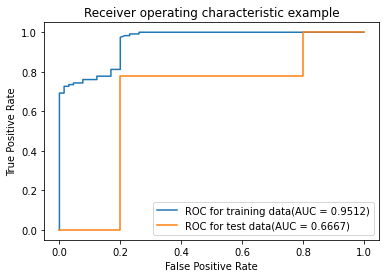

In [9]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_array):
    X_train, X_test = feature_array[train_index], feature_array[test_index]
    y_train, y_test = class_array[train_index], class_array[test_index]
    
    clf_nb = CategoricalNB(class_prior = [0.2,0.8], alpha = 0)
    clf_nb.fit(X_train,y_train)    

    posterior_trn = clf_nb.predict_proba(X_train)
    posterior_tst = clf_nb.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

# false positive rate, true positionve rate の計算
fpr_train, tpr_train, threshold_train = roc_curve(y_train_list, y_train_post_list)
fpr_test, tpr_test, threshold_test = roc_curve(y_test_list, y_test_post_list)

# AUC score の計算
auc_train = roc_auc_score(y_train_list, y_train_post_list)
auc_test = roc_auc_score(y_test_list, y_test_post_list)

plt.plot(fpr_train, tpr_train, label = f'ROC for training data(AUC = {auc_train:.4})')
plt.plot(fpr_test, tpr_test, label = f'ROC for test data(AUC = {auc_test:.4})')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

In [10]:
print('feature', '      target')
for i,j in zip(feature_array, class_array):
    print(i,j)

feature       target
[2. 1. 0. 0.] 0.0
[2. 1. 0. 1.] 0.0
[0. 1. 0. 0.] 1.0
[1. 2. 0. 0.] 1.0
[1. 0. 1. 0.] 1.0
[1. 0. 1. 1.] 0.0
[0. 0. 1. 1.] 1.0
[2. 2. 0. 0.] 0.0
[2. 0. 1. 0.] 1.0
[1. 2. 1. 0.] 1.0
[2. 2. 1. 1.] 1.0
[0. 2. 0. 1.] 1.0
[0. 1. 1. 0.] 1.0
[1. 2. 0. 1.] 0.0


上ではゼロ除算の可能性があるために警告が出てきている．  
実際に上のデータの表より$P(0|w_2)$に関しては，そもそもクラス$0$データが存在しないため，アルゴリズムとして動かないことがわかる．  
sklearnの実装上そのようなデータが存在する際には非常に小さい値でゼロ除算を阻止するような実装になっていることが上の警告文からわかる．   
またテストデータに対するAUCの値は先程の$alpha = 1.0$よりも改善していることが確認できる

次に極端に$\alpha = 100$としてroc曲線を描く

True Label: [0.]
Posterior Probability: [[0.20368672 0.79631328]]
True Label: [0.]
Posterior Probability: [[0.21001298 0.78998702]]
True Label: [1.]
Posterior Probability: [[0.20311499 0.79688501]]
True Label: [1.]
Posterior Probability: [[0.2047303 0.7952697]]
True Label: [1.]
Posterior Probability: [[0.19539288 0.80460712]]
True Label: [0.]
Posterior Probability: [[0.19428075 0.80571925]]
True Label: [1.]
Posterior Probability: [[0.19684092 0.80315908]]
True Label: [0.]
Posterior Probability: [[0.20055525 0.79944475]]
True Label: [1.]
Posterior Probability: [[0.19849404 0.80150596]]
True Label: [1.]
Posterior Probability: [[0.19540799 0.80459201]]
True Label: [1.]
Posterior Probability: [[0.20474565 0.79525435]]
True Label: [1.]
Posterior Probability: [[0.20622981 0.79377019]]
True Label: [1.]
Posterior Probability: [[0.1938483 0.8061517]]
True Label: [0.]
Posterior Probability: [[0.20361144 0.79638856]]


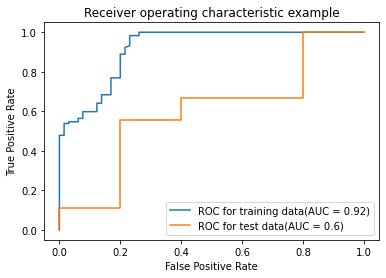

In [11]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_array):
    X_train, X_test = feature_array[train_index], feature_array[test_index]
    y_train, y_test = class_array[train_index], class_array[test_index]
    
    clf_nb = CategoricalNB(class_prior = [0.2,0.8], alpha = 100)
    clf_nb.fit(X_train,y_train)    

    posterior_trn = clf_nb.predict_proba(X_train)
    posterior_tst = clf_nb.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

# false positive rate, true positionve rate の計算
fpr_train, tpr_train, threshold_train = roc_curve(y_train_list, y_train_post_list)
fpr_test, tpr_test, threshold_test = roc_curve(y_test_list, y_test_post_list)

# AUC score の計算
auc_train = roc_auc_score(y_train_list, y_train_post_list)
auc_test = roc_auc_score(y_test_list, y_test_post_list)

plt.plot(fpr_train, tpr_train, label = f'ROC for training data(AUC = {auc_train:.4})')
plt.plot(fpr_test, tpr_test, label = f'ROC for test data(AUC = {auc_test:.4})')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

上ではどんな特徴量が入ってこようが全ての入力に対して同じ尤度を返してしまうので予測値はほぼ事前分布のままを出力することとなる．  
上の表でもテストデータに対しての事後確率の出力値がほぼ[0.2, 0.8]で固定されていることが確認できる．  
また，この時のテストデータに対するACUの値は上の二つの状況に比べて落ちていることが読み取れる．  
これは，明らかに表現力が落ちていることよりも納得がいく．

続いてスムージングパラメータ$\alpha$の値に対してどのようにAUCの値が推移していくのかを図示する.

In [12]:
def ret_auc(alpha = 1.0, prior = [0.2,0.8]):
    y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_array):
        X_train, X_test = feature_array[train_index], feature_array[test_index]
        y_train, y_test = class_array[train_index], class_array[test_index]

        clf_nb = CategoricalNB(class_prior = prior, alpha = alpha)
        clf_nb.fit(X_train,y_train)    

        posterior_trn = clf_nb.predict_proba(X_train)
        posterior_tst = clf_nb.predict_proba(X_test)

        # テストデータの正解クラスと事後確率を出力
#        print("True Label:", y_test)
#        print("Posterior Probability:", posterior_tst)

        # 正解クラスと事後確率を保存
        y_train_post_list.extend(posterior_trn[:,[1]])
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst[0][1])
        y_test_list.extend(y_test)

    # false positive rate, true positionve rate の計算
    fpr_train, tpr_train, threshold_train = roc_curve(y_train_list, y_train_post_list)
    fpr_test, tpr_test, threshold_test = roc_curve(y_test_list, y_test_post_list)

    # AUC score の計算
    auc_train = roc_auc_score(y_train_list, y_train_post_list)
    auc_test = roc_auc_score(y_test_list, y_test_post_list)
    
    return auc_train, auc_test

In [13]:
alpha = list(range(100))
auc_alpha = np.array([list(ret_auc(a+1e-10)) for a in alpha])

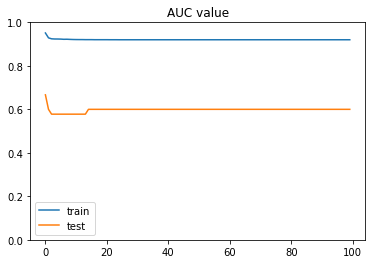

In [14]:
plt.plot(alpha, auc_alpha[:,0], label = 'train')
plt.plot(alpha, auc_alpha[:,1], label = 'test')
plt.ylim([0,1])
plt.title('AUC value')
plt.legend()

グラフより今回のデータセットにおいては$alpha$の値は小さいほどよく2から10くらいの値ではテスト性能が著しく落ち，それ以降は上で見たようにほぼ事後分布を出力するようになり，一定値を取ることが読み取れる．  
一般にはデータセットによって最適な$\alpha$は異なるはずなので，ここで行ったようにクロスバリデーションなどによってそのデータセットにあった$alpha$を探索することが求められる．  

## 課題4-3 事前確率の変化による性能の変化

事前確率分布は[p, 1-p]として表せるので，これを0から1まで変化させたときにどのようなAUCの値を出すかの遷移を図示する

In [15]:
prior = np.linspace(0+1e-10,1-1e-10,100)
auc_prior = np.array([list(ret_auc(prior = [p, 1-p])) for p in prior])

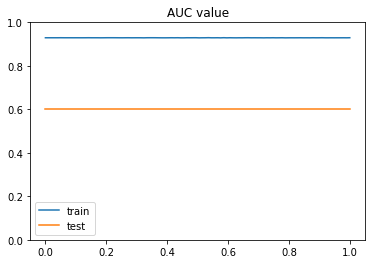

In [16]:
plt.plot(prior, auc_prior[:,0], label = 'train')
plt.plot(prior, auc_prior[:,1], label = 'test')
plt.ylim([0,1])
plt.title('AUC value')
plt.legend()

上のグラフより，事前分布の値によってはAUCの値は変化しないことが読み取れる．  
一方で正答率に関しては

In [17]:
def ret_auc(alpha = 1.0, prior = [0.2,0.8]):
    y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_array):
        X_train, X_test = feature_array[train_index], feature_array[test_index]
        y_train, y_test = class_array[train_index], class_array[test_index]

        clf_nb = CategoricalNB(class_prior = prior, alpha = alpha)
        clf_nb.fit(X_train,y_train)    

        posterior_trn = clf_nb.predict(X_train)
        posterior_tst = clf_nb.predict(X_test)

        # テストデータの正解クラスと事後確率を出力
#        print("True Label:", y_test)
#        print("Posterior Probability:", posterior_tst)

        # 正解クラスと事後確率を保存
        y_train_post_list.extend(posterior_trn)
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst)
        y_test_list.extend(y_test)
    
    a,b,c,d = np.array(y_train_post_list), np.array(y_train_list), np.array(y_test_post_list), np.array(y_test_list)
    c = c.reshape(len(c))
    return (a==b).sum() / len(a), (c==d).sum() / len(c)

In [18]:
prior = np.linspace(0+1e-10,1-1e-10,100)
auc_prior = np.array([list(ret_auc(prior = [p, 1-p])) for p in prior])

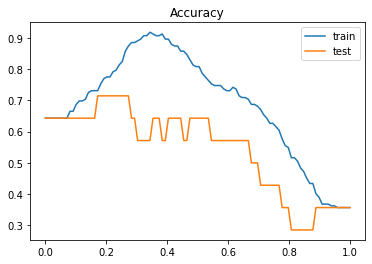

In [19]:
plt.plot(prior, auc_prior[:,0], label = 'train')
plt.plot(prior, auc_prior[:,1], label = 'test')
#plt.ylim([0,1])
plt.title('Accuracy')
plt.legend()

グラフより正答率に関しては事前分布が[0.4,0.6]あたりで良い性能を示しており，そこから遠ざかるにつれて正答率が下がっていくという結果が得られた．

ここで今回のデータセットについて確認すると  
ラベル 0 のデータ 5個  
ラベル 1 のデータ 9個  

となっており，事前分布は

In [20]:
print([5/14,9/14])

[0.35714285714285715, 0.6428571428571429]


となり，　これはグラフにおいてp = 0.4付近において良い性能を示していることよりも合致している．  

以上見てきたように特に理由がない場合やデータ数が十分多い場合には自分で事前分布を設定することなく学習データから事前分布を計算させるデフォルトの仕様に任せたほうが良いことが確認できた．  
一方でデータ数が少ない場合や，何かしらのドメイン知識を有する場合は，事前分布にそれらの事前情報を考慮することで性能を向上させることができると予想される．  